<a href="https://colab.research.google.com/github/gongx030/Etv2_pioneer/blob/master/Brg1_KD_sustained_Etv2_peaks_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Brg1 KD ATAC-seq data at D7

by Wuming Gong



In [ ]:
start_time0 <- Sys.time()

### Install external packages

In [ ]:
system('apt-get -q install libgsl-dev', intern = TRUE)

[1] "Reading package lists..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
 [2] "Building dependency tree..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
 [3] "Reading state information..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
 [4] "The following additional packages will be installed:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
 [5] "  libgsl23 libgslcblas0"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
 [6] "Suggested packages:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
 [7] "  gsl-ref-psdoc | gsl-doc-pdf | gsl-doc-info | gsl-ref-html"                                                           

In [ ]:
system('apt-get install libcairo2-dev', intern = TRUE) # for Cairo package that is required by ComplexHeatmap package

[1] "Reading package lists..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
 [2] "Building dependency tree..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
 [3] "Reading state information..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
 [4] "The following additional packages will be installed:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
 [5] "  libcairo-script-interpreter2 libpixman-1-dev libxcb-shm0-dev"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
 [6] "Suggested packages:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
 [7] "  libcairo2-doc"                                                                                                       

### Install R packages

In [ ]:
install.packages('BiocManager')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
required_packages <- c(
  'devtools', 'circlize', 'dplyr', 'gplots',
  'SummarizedExperiment', 'BiocParallel', 'ComplexHeatmap', 
  'rtracklayer', 'EnrichedHeatmap', 'ChIPpeakAnno', 'ChIPseeker', 'TxDb.Mmusculus.UCSC.mm10.knownGene', 
  'org.Mm.eg.db', 'clusterProfiler', 'ReactomePA'
)

In [ ]:
missing_packages <- required_packages[!required_packages %in% rownames(installed.packages())]
if (length(missing_packages) > 0){
    BiocManager::install(missing_packages)
}

Bioconductor version 3.12 (BiocManager 1.30.10), R 4.0.3 (2020-10-10)

Installing package(s) 'ComplexHeatmap', 'EnrichedHeatmap'

also installing the dependency ‘Cairo’


Old packages: 'diffobj', 'DT', 'gdtools', 'xfun', 'Matrix'



### Load R packages

In [ ]:
library(BiocParallel)
register(MulticoreParam(2))
library(SummarizedExperiment)
library(gplots)
library(circlize)
library(dplyr)
library(ComplexHeatmap)
library(EnrichedHeatmap)
library(rtracklayer)
library(parallel)
library(ChIPpeakAnno)
library(ChIPseeker)
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
library(org.Mm.eg.db)
library(clusterProfiler)
library(ReactomePA)

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, ro

## Get sustained Etv2 ChIP-seq peaks
Split the Etv2 MEF D1 peaks into three groups
* on at D1 and off at D7 (early)
* off at D1 and on at D7 (late)
* on at both D1 and D7 (sustained)

In [ ]:
gr_url <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/all_Etv2_peaks.rds' 
gr <- readRDS(gzcon(url(gr_url)))
peaks <- gr[gr$group[, 'MEF_Dox_d1_Etv2'] | gr$group[, 'MEF_Dox_d7_Etv2']]
peaks

GRanges object with 127559 ranges and 4 metadata columns:
           seqnames            ranges strand |                peak_id     score
              <Rle>         <IRanges>  <Rle> |            <character> <numeric>
       [1]     chr1   3037784-3037983      * | /panfs/roc/scratch/g..  16.22768
       [2]     chr1   3490314-3490513      * | /panfs/roc/scratch/g..  12.29730
       [3]     chr1   3531626-3531825      * | /panfs/roc/scratch/g..  16.22768
       [4]     chr1   3671125-3671324      * | /panfs/roc/scratch/g..   6.73792
       [5]     chr1   3671746-3671945      * | /panfs/roc/scratch/g..   9.54304
       ...      ...               ...    ... .                    ...       ...
  [127555]     chrY 90828936-90829135      * | /panfs/roc/scratch/g.. 160.15463
  [127556]     chrY 90836259-90836458      * | /panfs/roc/scratch/g..   8.27339
  [127557]     chrY 90841624-90841823      * | /panfs/roc/scratch/g..   1.53792
  [127558]     chrY 90842563-90842762      * | /panfs/roc/scra

Select the sustained Etv2 ChIP-seq peaks that are present in both D1 and D7 post induction.

In [ ]:
is_sustained <- peaks$group[, 'MEF_Dox_d1_Etv2'] & peaks$group[, 'MEF_Dox_d7_Etv2']
peaks_sustained <- peaks[is_sustained]
cat(sprintf('# of sustained Etv2 ChIP-seq peaks: %d', sum(is_sustained)))

# of sustained Etv2 ChIP-seq peaks: 12170

## Download MACS2 pileup files of ATAC-seq

In [ ]:
bw_files <- c(
  'MEF_Dox_D1_Etv2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d1_Etv2_FE.bw',
  'MEF_Dox_D2_Etv2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d2_Etv2_FE.bw',
  'MEF_Dox_D7_Etv2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d7_Etv2_FE.bw',
  'MEF_NoDox_Brg1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_NoDox_d0_Brg1_FE.bw',
  'MEF_Dox_D1_Brg1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d1_Brg1_FE.bw',
  'MEF_Dox_D2_Brg1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d2_Brg1_FE.bw',
  'MEF_Dox_D7_Brg1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d7_Brg1_FE.bw',
  'MEF_Brg1_KD_D0' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_D0_treat_pileup.bw',
  'MEF_Brg1_KD_Dox_D1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_Dox_D1_treat_pileup.bw',
  'MEF_Brg1_KD_Dox_D2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_Dox_D2_treat_pileup.bw',
  'MEF_Brg1_KD_Dox_D7' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_Dox_D7_treat_pileup.bw',
  'MEF_Brg1_KD_NoDox_D1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_NoDox_D1_treat_pileup.bw',
  'MEF_Brg1_KD_NoDox_D2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_NoDox_D2_treat_pileup.bw',
  'MEF_Brg1_KD_NoDox_D7' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_NoDox_D7_treat_pileup.bw',
  'MEF_Dox_D1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D1_treat_pileup.bw',
  'MEF_Dox_D2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D2_treat_pileup.bw',
  'MEF_Dox_D7' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_treat_pileup.bw',
  'MEF_Dox_D7_Flk1pos' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_Flk1pos_treat_pileup.bw',
  'MEF_NoDox' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_NoDox_treat_pileup.bw'
)

Download MACS2 pileup files (in BigWig format)
It appears that `rtracklayer::import` does not support importing bigwig files with URL starting with 'https://'.  We need to download the bigwig files first.


In [ ]:
local_bw_files <- gsub('https://s3.msi.umn.edu/', './', bw_files)
commands <- sprintf('wget -x -c -nH %s', bw_files)
res <- lapply(commands, function(command) system(command))
stopifnot(all(file.exists(local_bw_files)))

## Read the ATAC-seq summits

In [ ]:
# ATAC-seq summits of Brg1 KD at D7 post Etv2 induction
bed_file <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_Dox_D7_summits.bed'
peaks_Brg1KD_D7 <- read.table(bed_file, header = FALSE, sep = '\t')
peaks_Brg1KD_D7 <- GRanges(seqnames = peaks_Brg1KD_D7[, 1], range = IRanges(peaks_Brg1KD_D7[, 2], peaks_Brg1KD_D7[, 3]))

# ATAC-seq summits WT MEF reprogramming at D7 post Etv2 induction
bed_file <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_Flk1pos_summits.bed'
peaks_D7_Flk1pos <- read.table(bed_file, header = FALSE, sep = '\t')
peaks_D7_Flk1pos <- GRanges(seqnames = peaks_D7_Flk1pos[, 1], range = IRanges(peaks_D7_Flk1pos[, 2], peaks_D7_Flk1pos[, 3]))

# ATAC-seq blacklist
bed_file <- 'https://s3.msi.umn.edu/gongx030/datasets/datasets=blacklists_version=20190827a/mm10.blacklist.bed.gz'
peaks_blacklist <- gzcon(url(bed_file))
peaks_blacklist <- readLines(peaks_blacklist)
peaks_blacklist <- read.table(textConnection(peaks_blacklist), header = FALSE, sep = '\t')
peaks_blacklist <- GRanges(seqnames = peaks_blacklist[, 1], range = IRanges(peaks_blacklist[, 2], peaks_blacklist[, 3]))

## get_normalizeToMatrix
Generate the normalizeToMatrix object for visualizing ChIP-seq-like data by `EnrichedHeatmap`. 

In [ ]:
extend <- 1000
w <- 50
smooth <- FALSE
target_ratio <- 0.2
mc.cores <- 2
target_width <- width(peaks_sustained)[1]
cat(sprintf('# peaks: %d\n', length(peaks_sustained)))
cat(sprintf('target width: %d\n', target_width))

# peaks: 12170
target width: 200


In [ ]:
get_normalizeToMatrix <- function(bw_file, peaks, extend, w, smooth = FALSE, target_ratio = 0.2, ...){
  cvg <- rtracklayer::import(bw_file, which = trim(GenomicRanges::reduce(resize(peaks, fix = 'center', width = target_width + extend * 2))))  # returned as a GRanges object
  mat <- normalizeToMatrix(cvg, peaks, extend = extend, value_column = 'score', mean_mode = 'w0', w = w, smooth = smooth, target_ratio = target_ratio, ...)
  mat
} # get_normalizeToMatrix

## Prepare normalized matrix for EnrichedHeatmap
This step takes ~10 mins

In [ ]:
mat <- mclapply(local_bw_files, function(bw_file){
  cvg <- rtracklayer::import(
    bw_file, 
    which = trim(GenomicRanges::reduce(resize(peaks_sustained, fix = 'center', width = target_width + extend * 2)))
  )  # returned as a GRanges object
  normalizeToMatrix(
    cvg, 
    peaks_sustained, 
    extend = extend, 
    value_column = 'score', 
    mean_mode = 'w0', 
    w = w, 
    smooth = smooth, 
    target_ratio = target_ratio
  )
}, mc.cores = 2)

## Make the heatmap

Color scheme of the heatmap

In [ ]:
group_cols <- c(
  'MEF_Dox_D1_Etv2' = 'red',
  'MEF_Dox_D2_Etv2' = 'red',
  'MEF_Dox_D7_Etv2' = 'red',
  'MEF_NoDox_Brg1' = 'purple',
  'MEF_Dox_D1_Brg1' = 'purple',
  'MEF_Dox_D2_Brg1' = 'purple',
  'MEF_Dox_D7_Brg1' = 'purple',
  'MEF_Brg1_KD_D0' = 'blue',
  'MEF_Brg1_KD_Dox_D1' = 'blue',
  'MEF_Brg1_KD_Dox_D2' = 'blue',
  'MEF_Brg1_KD_Dox_D7' = 'blue',
  'MEF_Brg1_KD_NoDox_D1' = 'blue',
  'MEF_Brg1_KD_NoDox_D2' = 'blue',
  'MEF_Brg1_KD_NoDox_D7' = 'blue',
  'MEF_Dox_D1' = 'blue',
  'MEF_Dox_D2' = 'blue',
  'MEF_Dox_D7' = 'blue',
  'MEF_Dox_D7_Flk1pos' = 'blue',
  'MEF_NoDox' = 'blue'
)
col_fun <- lapply(1:length(mat), function(i) colorRamp2(quantile(mat[[i]], c(0.005, 0.995)), c('white', group_cols[i])))
names(col_fun) <- names(bw_files)

In [ ]:
open_Brg1KD_D7 <- peaks_sustained %over% peaks_Brg1KD_D7
open_D7_Flk1pos <-peaks_sustained %over% peaks_D7_Flk1pos
is_black <- peaks_sustained %over% peaks_blacklist

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FA

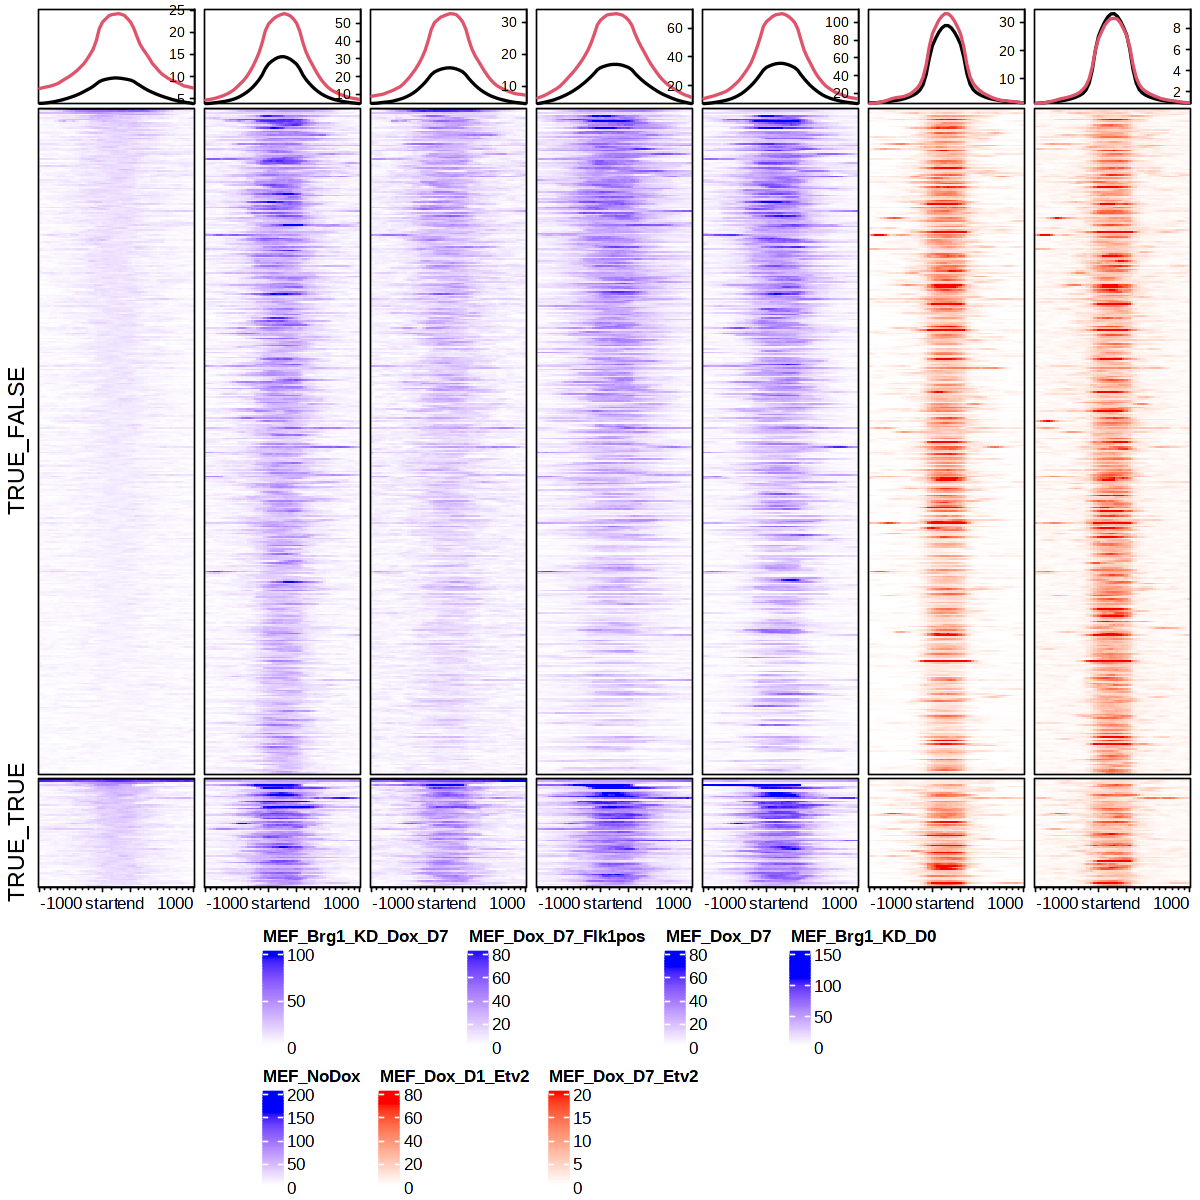

In [ ]:
i <- which(open_D7_Flk1pos & !is_black)
sp <- factor(sprintf('%s_%s', open_D7_Flk1pos, open_Brg1KD_D7))
              
ta <- HeatmapAnnotation(
  enriched = anno_enriched(
    gp = gpar(lty = 1, lwd = 2, col = 1:nlevels(sp)), 
    axis_param = list(facing = 'inside')
  )
)
h <- EnrichedHeatmap(
  mat[['MEF_Brg1_KD_Dox_D7']][i, ], 
  col = col_fun[['MEF_Brg1_KD_Dox_D7']], 
  split = sp[i], 
  name = 'MEF_Brg1_KD_Dox_D7', 
  top_annotation = ta, 
  pos_line = FALSE
)
ss <- c(
  'MEF_Dox_D7_Flk1pos','MEF_Dox_D7',
  'MEF_Brg1_KD_D0', 'MEF_NoDox',
  'MEF_Dox_D1_Etv2', 'MEF_Dox_D7_Etv2'
)
for (s in ss[ss %in% names(bw_files)]){
  h <- h + EnrichedHeatmap(mat[[s]][i, ], col = col_fun[[s]], name = s, top_annotation = ta, pos_line = FALSE)
}
options(repr.plot.width = 10, repr.plot.height = 10)
draw(h, heatmap_legend_side = 'bottom')

The sustaina Etv2 peaks can be dividied into two groups

* Group 1: closed in Brg1 KO at D7 (TRUE_FALSE)
* Group 2: open in Brg1 KO at D7 (TRUE_TRUE)

## Annotating open vs. closed Etv2 peaks (sustained)

In [ ]:
peak_list <- list(
  open = peaks_sustained[open_D7_Flk1pos & open_Brg1KD_D7],
  closed = peaks_sustained[open_D7_Flk1pos & !open_Brg1KD_D7]
)
anno_list <- lapply(peak_list, function(p)
  annotatePeak(p, tssRegion = c(-5000, 1000), TxDb = TxDb.Mmusculus.UCSC.mm10.knownGene, annoDb = "org.Mm.eg.db")
)


>> preparing features information...		 2021-01-11 12:52:46 AM 
>> identifying nearest features...		 2021-01-11 12:52:47 AM 
>> calculating distance from peak to TSS...	 2021-01-11 12:52:48 AM 
>> assigning genomic annotation...		 2021-01-11 12:52:48 AM 
>> adding gene annotation...			 2021-01-11 12:53:07 AM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2021-01-11 12:53:07 AM 
>> done...					 2021-01-11 12:53:07 AM 
>> preparing features information...		 2021-01-11 12:53:07 AM 
>> identifying nearest features...		 2021-01-11 12:53:07 AM 
>> calculating distance from peak to TSS...	 2021-01-11 12:53:08 AM 
>> assigning genomic annotation...		 2021-01-11 12:53:08 AM 
>> adding gene annotation...			 2021-01-11 12:53:10 AM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2021-01-11 12:53:11 AM 
>> done...					 2021-01-11 12:53:11 AM 


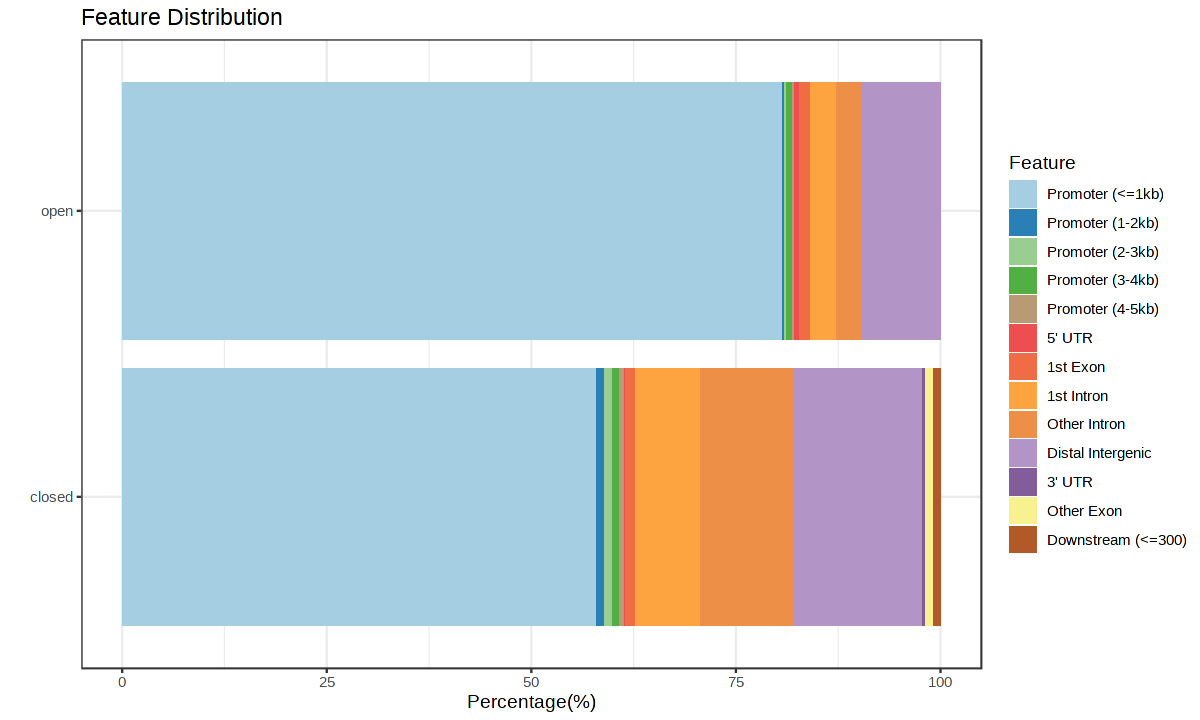

In [ ]:
options(repr.plot.width=10, repr.plot.height=6)
plotAnnoBar(anno_list)

In [ ]:
Sys.time() - start_time0

Time difference of 1.232774 hours

In [ ]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] ReactomePA_1.34.0                        
 [2] clusterProfiler_3.18.0                   
 [3] org.Mm.eg.db_3.12.0                      
 [4] TxDb.Mmusculus.UCSC.mm10.knownGene_3.10.0
 [5] GenomicFeatures_1.42.1                   